In [ ]:
#Download the GOPRO dataset
!mkdir datasets && cd datasets


In [ ]:
!pip install kaggle


In [ ]:
# Move kaggle.json to the correct directory and set permissions
import shutil
import os
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

In [ ]:
!kaggle datasets download -d jesucristo/gopro-data


Dataset URL: https://www.kaggle.com/datasets/jesucristo/gopro-data
License(s): unknown


In [ ]:
!unzip gopro-data.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/GOPR0374_11_02/blur_gamma/000546.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000547.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000548.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000549.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000550.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000551.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000552.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000553.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000554.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000555.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000556.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000557.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000558.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000559.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000560.png  
  inflating: train/GOPR0374_11_02/blur_gamma/000561.png  
  inflating: train/GO

In [ ]:
%cd ..

/


In [ ]:
!ls /content/GOPRO


test  train


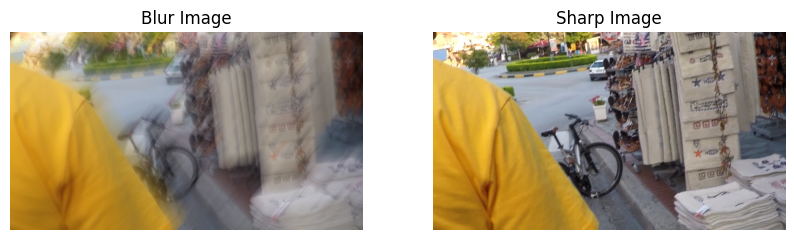

Batch shape (blur): torch.Size([4, 3, 720, 1280]), Batch shape (sharp): torch.Size([4, 3, 720, 1280])


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader

# Set dataset path (update accordingly)
DATASET_PATH = "/content/GOPRO/train"

# Function to load and visualize a sample image pair
def visualize_sample(sequence="GOPR0374_11_00", img_index=1):
    blur_path = os.path.join(DATASET_PATH, sequence, "blur", f"{img_index:06d}.png")
    sharp_path = os.path.join(DATASET_PATH, sequence, "sharp", f"{img_index:06d}.png")

    if not os.path.exists(blur_path) or not os.path.exists(sharp_path):
        print(f"Image {img_index:06d}.png not found in sequence {sequence}")
        return

    # Load images
    blur_img = cv2.imread(blur_path)
    sharp_img = cv2.imread(sharp_path)

    # Convert BGR (OpenCV default) to RGB
    blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB)
    sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB)

    # Plot images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(blur_img)
    ax[0].set_title("Blur Image")
    ax[0].axis("off")

    ax[1].imshow(sharp_img)
    ax[1].set_title("Sharp Image")
    ax[1].axis("off")

    plt.show()

# Example: Visualize an image pair
visualize_sample(sequence="GOPR0374_11_00", img_index=1)

# PyTorch Dataset Class
class GoProDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.sequences = sorted(os.listdir(root_dir))
        self.image_pairs = []

        for seq in self.sequences:
            blur_dir = os.path.join(root_dir, seq, "blur")
            sharp_dir = os.path.join(root_dir, seq, "sharp")

            if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
                blur_images = sorted(glob(os.path.join(blur_dir, "*.png")))
                sharp_images = sorted(glob(os.path.join(sharp_dir, "*.png")))

                for b_img, s_img in zip(blur_images, sharp_images):
                    self.image_pairs.append((b_img, s_img))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        blur_path, sharp_path = self.image_pairs[idx]

        # Load images
        blur_img = cv2.imread(blur_path)
        sharp_img = cv2.imread(sharp_path)

        # Convert BGR to RGB and Normalize
        blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB) / 255.0
        sharp_img = cv2.cvtColor(sharp_img, cv2.COLOR_BGR2RGB) / 255.0

        # Convert to PyTorch Tensors
        blur_tensor = torch.tensor(blur_img, dtype=torch.float32).permute(2, 0, 1)
        sharp_tensor = torch.tensor(sharp_img, dtype=torch.float32).permute(2, 0, 1)

        return blur_tensor, sharp_tensor

# Create dataset and dataloader
dataset = GoProDataset(DATASET_PATH)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Example: Load a batch
batch_blur, batch_sharp = next(iter(dataloader))
print(f"Batch shape (blur): {batch_blur.shape}, Batch shape (sharp): {batch_sharp.shape}")


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return torch.sigmoid(x)  # Normalize output between 0 and 1

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeblurCNN().to(device)


In [ ]:
# Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training Loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for blur_imgs, sharp_imgs in dataloader:
        blur_imgs, sharp_imgs = blur_imgs.to(device), sharp_imgs.to(device)

        # Forward Pass
        optimizer.zero_grad()
        output = model(blur_imgs)

        # Compute Loss
        loss = criterion(output, sharp_imgs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}")


Epoch [1/5], Loss: 0.0058
Epoch [2/5], Loss: 0.0036
Epoch [3/5], Loss: 0.0036
Epoch [4/5], Loss: 0.0036
Epoch [5/5], Loss: 0.0036


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "/content/deblur_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# Load the model for testing
model = DeblurCNN().to(device)
model.load_state_dict(torch.load("/content/deblur_model.pth", map_location=device))
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


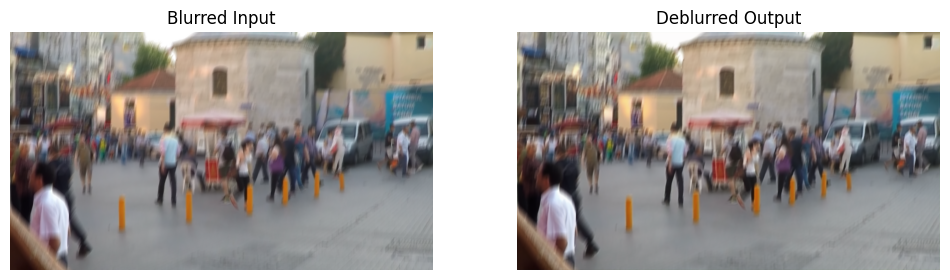

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the test image path
TEST_IMAGE_PATH = "/content/GOPRO/test/GOPR0384_11_00/blur/000002.png"  # Change filename if needed

# Function to test the model on a new image
def test_on_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found at: {image_path}")
        return

    # Load the blurred test image
    blur_img = cv2.imread(image_path)
    blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB) / 255.0  # Normalize to [0,1]

    # Convert to PyTorch tensor and reshape
    blur_tensor = torch.tensor(blur_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # Pass through model
    with torch.no_grad():
        deblurred_tensor = model(blur_tensor).squeeze(0).cpu()

    # Convert back to numpy image
    deblurred_img = np.clip(deblurred_tensor.numpy().transpose(1, 2, 0), 0, 1)  # Ensure valid image range

    # Display images
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].imshow(blur_img)
    axes[0].set_title("Blurred Input")
    axes[0].axis("off")

    axes[1].imshow(deblurred_img)
    axes[1].set_title("Deblurred Output")
    axes[1].axis("off")

    plt.show()

# Run test
test_on_image(TEST_IMAGE_PATH)


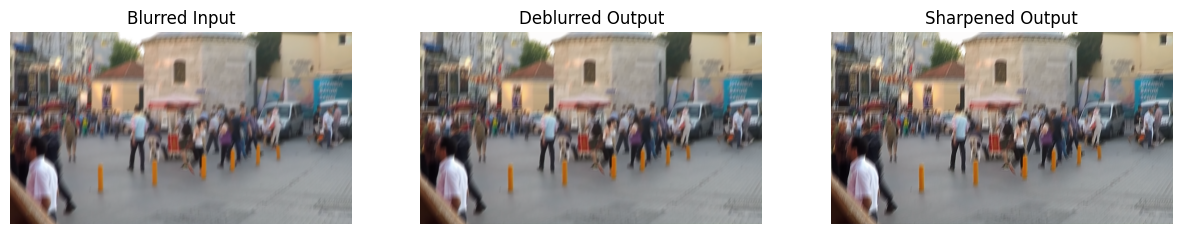

In [ ]:
import cv2
import numpy as np

def sharpen_image(image):
    """Applies a sharpening filter to enhance image details."""
    kernel = np.array([[0, -1, 0],
                       [-1,  5, -1],
                       [0, -1, 0]])  # Standard sharpening kernel
    sharpened = cv2.filter2D(image, -1, kernel)
    return np.clip(sharpened, 0, 1)  # Keep values in valid range

# Modify the test function to include sharpening
def test_on_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found at: {image_path}")
        return

    # Load the blurred test image
    blur_img = cv2.imread(image_path)
    blur_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2RGB) / 255.0

    # Convert to PyTorch tensor and reshape
    blur_tensor = torch.tensor(blur_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # Pass through model
    with torch.no_grad():
        deblurred_tensor = model(blur_tensor).squeeze(0).cpu()

    # Convert back to numpy image
    deblurred_img = np.clip(deblurred_tensor.numpy().transpose(1, 2, 0), 0, 1)

    # Apply sharpening
    sharpened_img = sharpen_image(deblurred_img)

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(blur_img)
    axes[0].set_title("Blurred Input")
    axes[0].axis("off")

    axes[1].imshow(deblurred_img)
    axes[1].set_title("Deblurred Output")
    axes[1].axis("off")

    axes[2].imshow(sharpened_img)
    axes[2].set_title("Sharpened Output")
    axes[2].axis("off")

    plt.show()

# Run test
test_on_image(TEST_IMAGE_PATH)
